# K-means Clustering

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
import functools
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [3]:
def hh_mm_ss2seconds(hh_mm_ss):
    return functools.reduce(lambda acc, x: acc*60 + x, map(int, hh_mm_ss.split(':')))

## Pre-Processing Data

In [20]:
# Paths to datasets
datasets = ['./Data/set1.csv', './Data/set2.csv', './Data/set3noVID.csv']

# Standardize features
features = ['SEQUENCE_DTTM', 'LAT', 'LON', 'SPEED_OVER_GROUND', 'COURSE_OVER_GROUND']

def process_dataset(file_path):
    df = pd.read_csv(file_path, converters={'SEQUENCE_DTTM' : hh_mm_ss2seconds})
    X = df[features]
    scaler = StandardScaler()
    return scaler.fit_transform(X)

# Load and pre-process each dataset
processed_data = [process_dataset(file) for file in datasets]

## Feature Selection
Use set1 & set2 to determing which features to choose

In [38]:
# Features for set1 and set2
X1 = processed_data[0]
X2 = processed_data[1]

# Labels for set1 and set2
y1 = pd.read_csv('./Data/set1.csv')['VID']
y2 = pd.read_csv('./Data/set2.csv')['VID']

num_clusters = 20 # unique VID in set1 and set2

from itertools import combinations

features = range(X1.shape[1])
best_score = 0
best_combo = None

for i in range(1, len(features) + 1):
    for combo in combinations(features, i):
        # Select the features for this combination for both sets
        X1_subset = X1[:, combo]
        X2_subset = X2[:, combo]

        # K-means clustering on Set 1
        kmeans1 = KMeans(n_clusters=num_clusters, random_state=40, n_init=10)
        predictions1 = kmeans1.fit_predict(X1_subset)
        score1 = adjusted_rand_score(y1, predictions1)

        # L-means clustering on Set 2
        kmeans2 = KMeans(n_clusters=num_clusters, random_state=40, n_init=10)
        predictions2 = kmeans2.fit_predict(X2_subset)
        score2 = adjusted_rand_score(y2, predictions2)

        # Calculate the average ARI
        average_score = (score1 + score2) / 2
        print(f"Testing features {combo}: Average ARI = {average_score}")

        # Check if this combination gave a better average score
        if average_score > best_score:
            best_score = average_score
            best_combo = combo

print(f"Best Average ARI: {best_score} with features {best_combo}")

Testing features (0,): Average ARI = 0.05351330426762283
Testing features (1,): Average ARI = 0.10241069791991846
Testing features (2,): Average ARI = 0.09775976165332279
Testing features (3,): Average ARI = 0.23748266681776056
Testing features (4,): Average ARI = 0.21352130872408087
Testing features (0, 1): Average ARI = 0.14115558950755677
Testing features (0, 2): Average ARI = 0.1673355560545245
Testing features (0, 3): Average ARI = 0.18939001526566368
Testing features (0, 4): Average ARI = 0.21100294411416085
Testing features (1, 2): Average ARI = 0.13190677488773156
Testing features (1, 3): Average ARI = 0.2453678262337739
Testing features (1, 4): Average ARI = 0.22243449529268178
Testing features (2, 3): Average ARI = 0.20200018607510134
Testing features (2, 4): Average ARI = 0.20519869677134472
Testing features (3, 4): Average ARI = 0.36555281222174446
Testing features (0, 1, 2): Average ARI = 0.2005819409769513
Testing features (0, 1, 3): Average ARI = 0.21792178346498986
Test

Seems like feature combination (3,4) SPEED_OVER_GROUND and COURSE_OVER_GROUND perform the best

## Select K
Use set3noVID to select number of clusters K

In [33]:
# Range for K
K_range = range(5, 50)

# Dataset 3
X3 = processed_data[2]
X3 = X3[:, 3:5] # Get featues 3 and 4 only

# Lists to store evaluation metrics
inertia = []
silhouette_scores = []

# For each K, apply k-means clustering and store eval metrics
for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=40, n_init=10)
    kmeans.fit(X3)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X3, kmeans.labels_))

### Silhouette Scores Plot

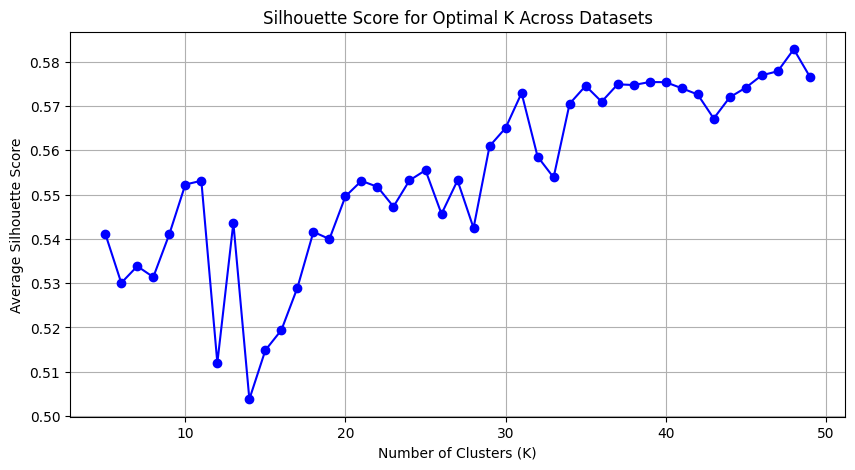

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, 'o-b')
plt.title('Silhouette Score for Optimal K Across Datasets')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.show()

### Elbow Plot

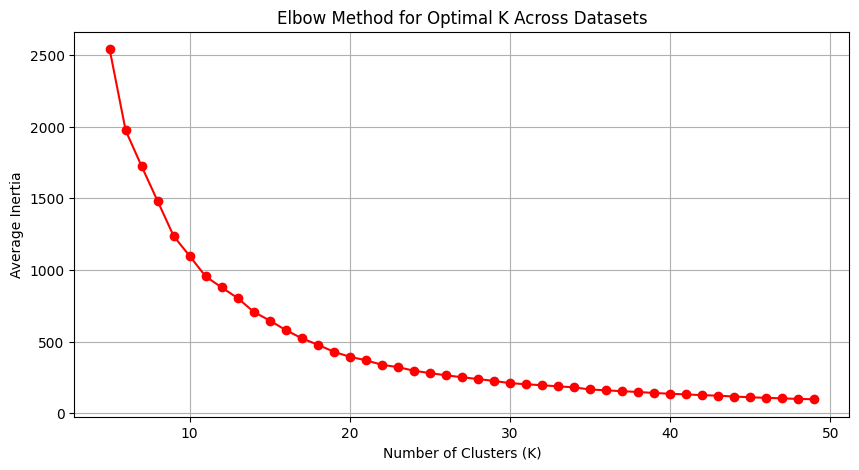

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, 'o-r')
plt.title('Elbow Method for Optimal K Across Datasets')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Inertia')
plt.grid(True)
plt.show()

Seems like values of K between 20 and 30 perform the best.

### Silhouette Plots for 20, 25, 30

For K=20 the average silhouette score is : 0.5496016905528843


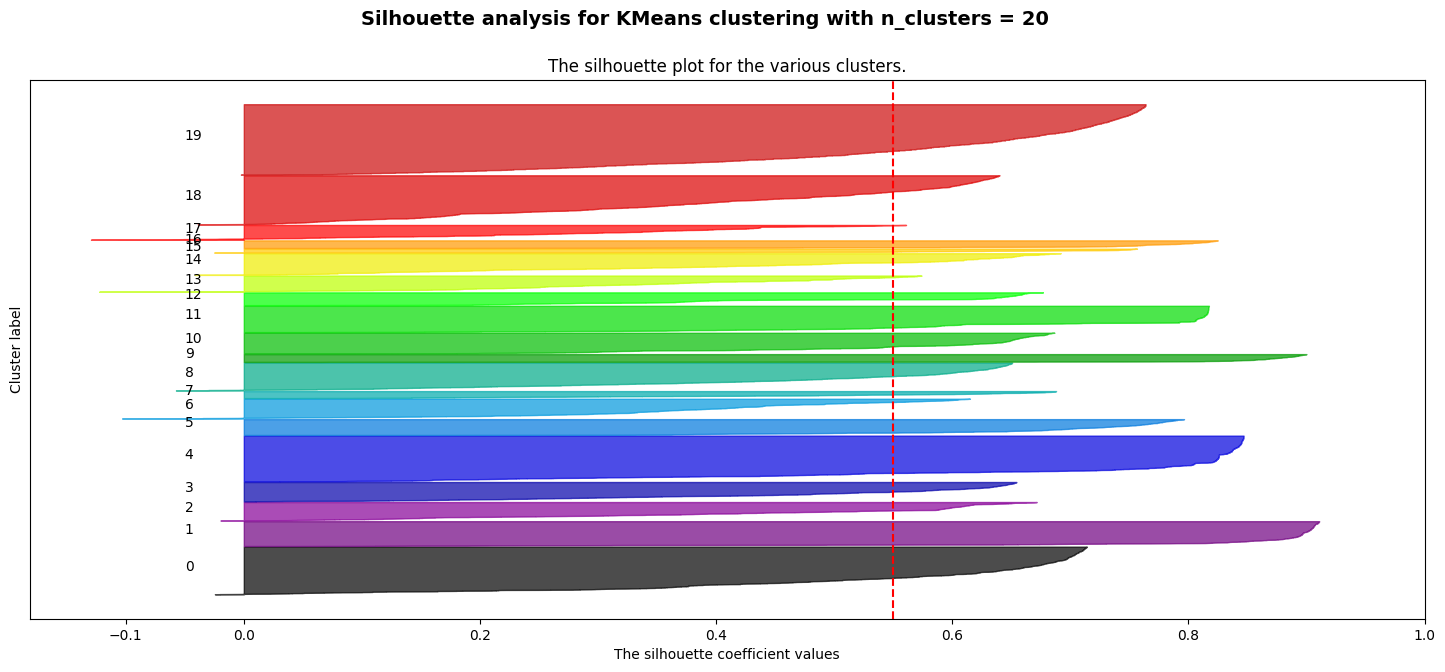

For K=25 the average silhouette score is : 0.5555095934618031


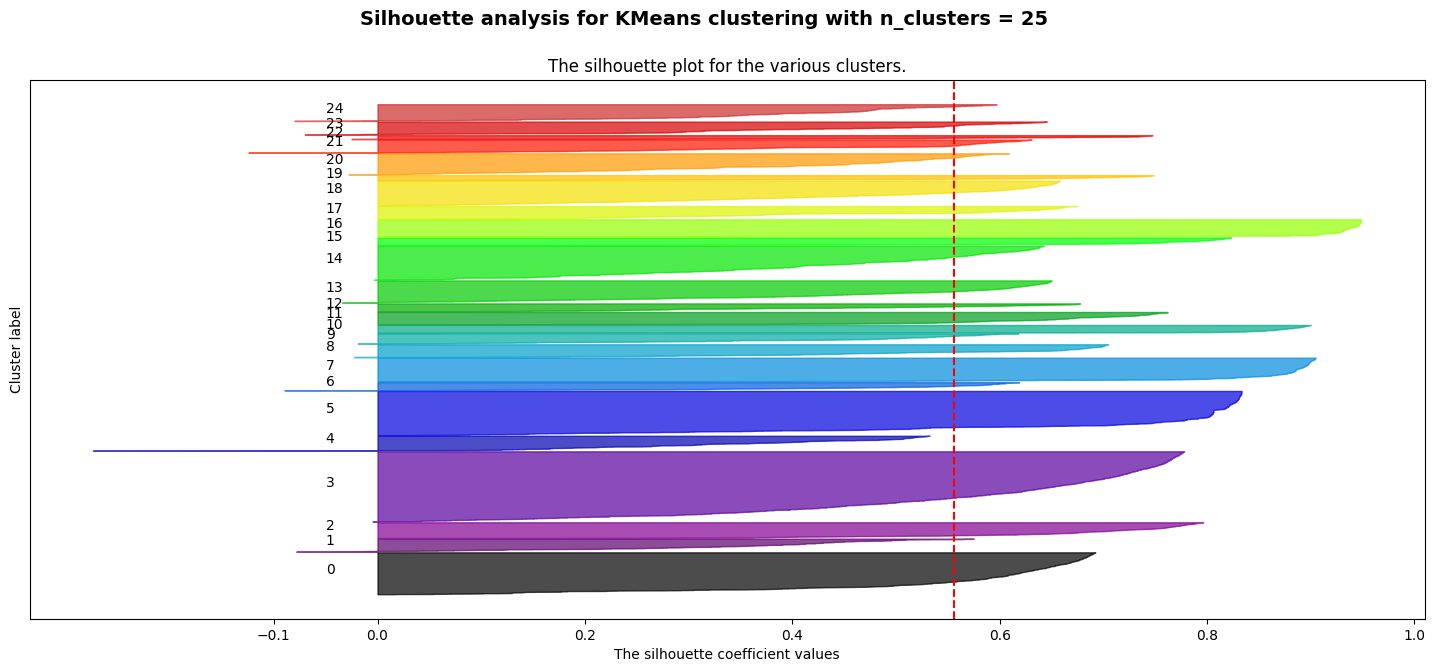

For K=30 the average silhouette score is : 0.5650406836796321


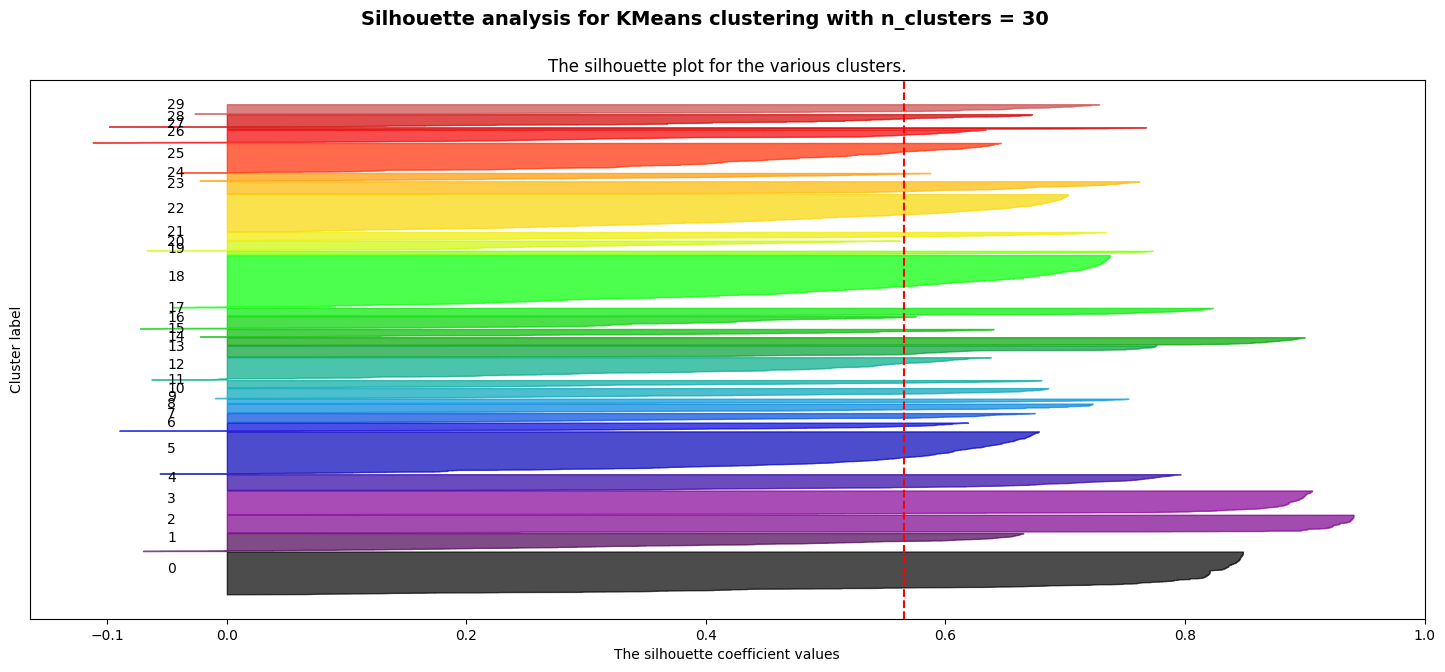

In [39]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

K_range = [20, 25, 30]

for K in K_range:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # Run K-means clustering
    kmeans = KMeans(n_clusters=K, random_state=40, n_init=10)
    cluster_labels = kmeans.fit_predict(X3)

    # Get silhouette scores for each sample
    silhouette_avg = silhouette_score(X3, cluster_labels)
    print(f"For K={K} the average silhouette score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X3, cluster_labels)

    y_lower = 10
    for i in range(K):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples gap between clusters

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle((f"Silhouette analysis for KMeans clustering with n_clusters = {K}"),
                 fontsize=14, fontweight='bold')
    plt.show()


We are going to go with K = 25 as a good trade off between 20 and 30.